In [2]:
!pip install aeronet --user

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import os
import sys
import numpy as np
import aeronet
import rasterio

In [2]:
import cv2
import numpy as np
from skimage.morphology import label
from skimage.morphology import disk

def read_image(path):
    return cv2.imread(path)[..., ::-1].copy()

def read_mask(path):
    return cv2.imread(path, 0)[..., ::-1].copy()

def read_mask(path):
    return cv2.imread(path, 0).squeeze() / 255


def rle_decode(rle_mask, shape):
    """
    :param rle_mask: run-length as string formated (start length)
    :param shape: (height,width) of array to return
    :return: numpy array, 1 - mask, 0 - background
    """
    s = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def multi_rle_decode(rle_masks: list, shape: tuple):
    # decode multiple RLE masks to one image
    all_masks = np.zeros(shape, dtype=np.int16)
    for mask in rle_masks:
        if isinstance(mask, str):
            all_masks += rle_decode(mask, shape=shape)
    return np.expand_dims(all_masks, -1)


def masks_as_overlap(rle_masks, shape, thickness=1):
    # decode multiple RLE masks to one image of masks overlapping regions
    # in other words return overlaps of input rle masks
    all_masks = np.zeros(shape, dtype=np.int16)
    kernel = disk(thickness)

    for mask in tqdm(rle_masks):
        if isinstance(mask, str):
            bin_mask = rle_decode(mask, shape=shape)
            bin_mask = cv2.dilate(bin_mask, kernel)
            all_masks += bin_mask

    overlap_masks = (all_masks > 1).astype(np.uint8)
    return np.expand_dims(overlap_masks, -1)

def rle_encode(img):
    """
    :param img: numpy array, 1 - mask, 0 - background
    :return: run length as string formated
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def multi_rle_encode(img, filter_small=10):
    labels = label(img, connectivity=1)
    
    rle_masks = []
    print(len(np.unique(labels[labels > 0])))
    for i, k in enumerate(np.unique(labels[labels > 0])):
        print(i, end='..')
        mask = (labels == k)
        if mask.sum() >= filter_small:
            rle_masks.append(rle_encode(mask))
    return rle_masks

def add_mask(image, mask, channel='r', intensity=100):

        r, g, b = image.transpose(2,0,1)
        mask = mask.squeeze() * intensity

        if channel == 'r':
            r = r.astype(np.uint16) + mask.astype(np.uint16)
            r = np.clip(r, 0, 255).astype(np.uint8)

        if channel == 'g':
            g = g.astype(np.uint16) + mask.astype(np.uint16)
            g = np.clip(g, 0, 255).astype(np.uint8)

        if channel == 'b':
            b = b.astype(np.uint16) + mask.astype(np.uint16)
            b = np.clip(b, 0, 255).astype(np.uint8)

        image = np.stack((r, g, b)).transpose(1,2,0)

        return image

In [3]:
import os
import cv2
import matplotlib.pyplot as plt

GT_DIR = '../../data/dataset/gt/'
GT_DIR

'../../data/dataset/gt/'

In [39]:
os.listdir(GT_DIR)

['buildings_GT.geojson',
 'P2MLF2MV9K9XIYUI.tif',
 'KHSF2T5PXCKI0978.tif',
 'ZRYNEEUSVQ213QTY.tif']

In [51]:
gt_images = {}

for img_name in os.listdir(GT_DIR):
    
    path = os.path.join(GT_DIR, img_name)
    
    if path.endswith('tif'):
        
        with rasterio.open(path, mode='r') as src:
            gt_images[img_name.split('.')[0]] = {
                'image': src.read().transpose(1,2,0), 
                'transform': src.transform, 
                'crs':src.crs,  
                }

In [54]:
TEST_DIR = '../../data/dataset/test_2/'

test_images = {}

for img_name in os.listdir(TEST_DIR):
    
    path = os.path.join(TEST_DIR, img_name)
    
    if path.endswith('png'):
        
        test_image = read_image('../../data/dataset/test_2/' + img_name)
        test_images[img_name.split('.')[0]] = {
                'image': test_image, 
                'transform': None, 
                'crs': None,  
                }

In [60]:
for k in gt_images.keys():
    
    h1, w1 = gt_images[k]['image'].shape[:2]
    h2, w2 = test_images[k]['image'].shape[:2]
    
    h_scale = h1/h2
    w_scale = w1/w2
    
    gt_tr = gt_images[k]['transform']
    
    test_tr = [gt_tr.a * w_scale,    gt_tr.b,            gt_tr.c,
               gt_tr.d,              gt_tr.e * h_scale,  gt_tr.f]
    
    test_images[k]['transform'] = test_tr
    test_images[k]['crs'] = gt_images[k]['crs']

### decode predictions

In [64]:
MASKS_DIR = '../../data/predictions/test_2/sub-1/'

test_masks = {}

for img_name in os.listdir(MASKS_DIR):
    
    path = os.path.join(TEST_DIR, img_name)
    
    if path.endswith('png'):
        
        test_mask = read_mask(os.path.join(MASKS_DIR, img_name))
        
        k = img_name.split('.')[0]
        test_masks[k] = {
                'image': test_mask, 
                'transform': test_images[k]['transform'], 
                'crs': test_images[k]['crs'],  
                }

In [84]:
from rasterio import Affine
from aeronet.dataset import Band, polygonize, BandSample, FeatureCollection

In [85]:
fc = FeatureCollection([], crs='epsg:3857')

In [86]:
for k, mask in test_masks.items():
    
    b = BandSample('100', mask['image'].astype('uint8'), transform=Affine(*mask['transform']), crs=mask['crs'])
    _fc = polygonize(b)
    
    fc.extend(_fc)

/home/user/.local/lib/python3.6/site-packages/aeronet/dataset/vector/feature.py:95: RuntimeWarning: Empty geometry detected. This geometry have been removed from collection.
  RuntimeWarning)


In [88]:
fc.save('../../data/predictions/sub-1.geojson')

/home/user/.local/lib/python3.6/site-packages/aeronet/dataset/vector/feature.py:52: RasterioDeprecationWarning: Comparison to str will be removed in 1.0
  if self.crs != CRS_LATLON:


In [95]:
gt_fc = FeatureCollection.read('../../data/dataset/gt/buildings_GT.geojson').reproject('epsg:3857')

In [91]:
from aeronet.criterions.vector import confusion_matrix

In [115]:
scores =[]

print('tr. IoU\t|  F2 Score')
print('--------------------')
for t in np.arange(0.5, 1, 0.05):
    
    tp, fp, fn = confusion_matrix(gt_fc, fc, iou_threshold=t)
    score = 5 * tp / (5 * tp + 4 * fn + fp)
    #score = 2 * tp / (2 * tp + fn + fp)
    print('   {:.03}\t|  {:.5}'.format(t, score))
    
    scores.append(score)

print('--------------------')
print()
print('Mean F2-score: {:.4}'.format(np.mean(scores)))

tr. IoU	|  F2 Score
--------------------
   0.5	|  0.84904
   0.55	|  0.84057
   0.6	|  0.81939
   0.65	|  0.80881
   0.7	|  0.78234
   0.75	|  0.75693
   0.8	|  0.70929
   0.85	|  0.62884
   0.9	|  0.45204
   0.95	|  0.12492
--------------------

Mean F2-score: 0.6772


In [116]:
sys.path.append('..')

In [117]:
from utils.metrics import f2_score

In [125]:
for mask in test_masks:
    print(mask, test_masks[mask]['image'].shape)

ZRYNEEUSVQ213QTY (7736, 6530)
P2MLF2MV9K9XIYUI (7735, 6529)
KHSF2T5PXCKI0978 (7734, 6528)


In [ ]:
def to_labeled_mask()

In [122]:
def f2_score(gt, pr):
    """
    Args:
        gt: np.array HxW; uint8, 0 - backgound, 1 - target class
        pr: np.array HxW; uint8, 0 - backgound, 1 - target class
    """
    
    if gt.sum() == 0 and pr.sum() == 0:
        return 1
    elif gt.sum() == 0 and pr.sum() > 0:
        return 0
    elif gt.sum() > 0 and pr.sum() == 0:
        return 0
    
    gt = label(gt, connectivity=1)
    pr = label(pr, connectivity=1)
    #print('GT ships: {}'.format(len(np.unique(gt) - 1)))
    #print('PR ships: {}'.format(len(np.unique(pr) - 1)))
    return calculate_ap(gt, pr, beta=2)


def calculate_ap(gt, pr, beta=1):
    
    labels = gt
    y_pred = pr
        
    # y_pred should also contain background labels
    # y_pred should contain it if it is taken from wt transform
        
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred)) 
    
    # Compute intersection between all objects
    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection 
    
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union   

    # Loop over IoU thresholds
    prec = []
    print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        p = (1 + beta**2) * tp / ((1 + beta**2) * tp + fp + beta**2 * fn)
        print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    
    return np.mean(prec)

# Precision helper function
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

In [123]:
f2_score(test_masks['ZRYNEEUSVQ213QTY']['image'], test_masks['ZRYNEEUSVQ213QTY']['image'])

Thresh	TP	FP	FN	Prec.
0.500	185	0	0	1.000
0.550	185	0	0	1.000
0.600	185	0	0	1.000
0.650	185	0	0	1.000
0.700	185	0	0	1.000
0.750	185	0	0	1.000
0.800	185	0	0	1.000
0.850	185	0	0	1.000
0.900	185	0	0	1.000
0.950	185	0	0	1.000
AP	-	-	-	1.000


1.0

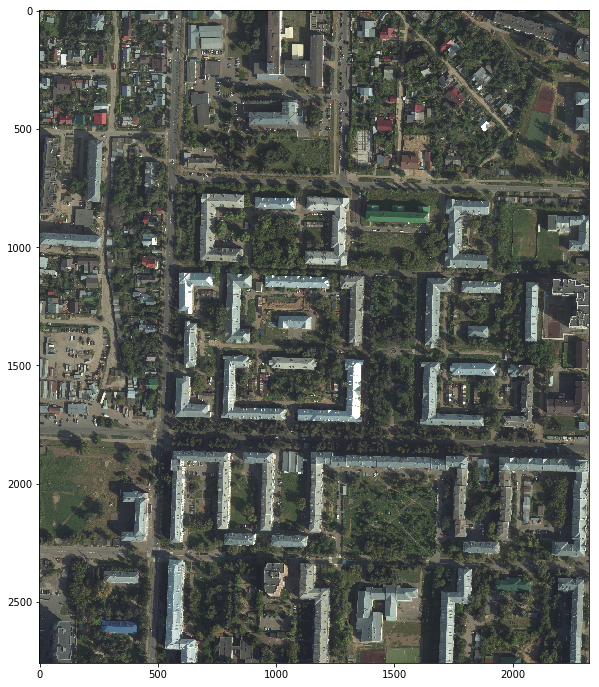

In [55]:
plt.figure(figsize=(12,12))
plt.imshow(gt_images['P2MLF2MV9K9XIYUI']['image'][::5, ::5])
plt.show()

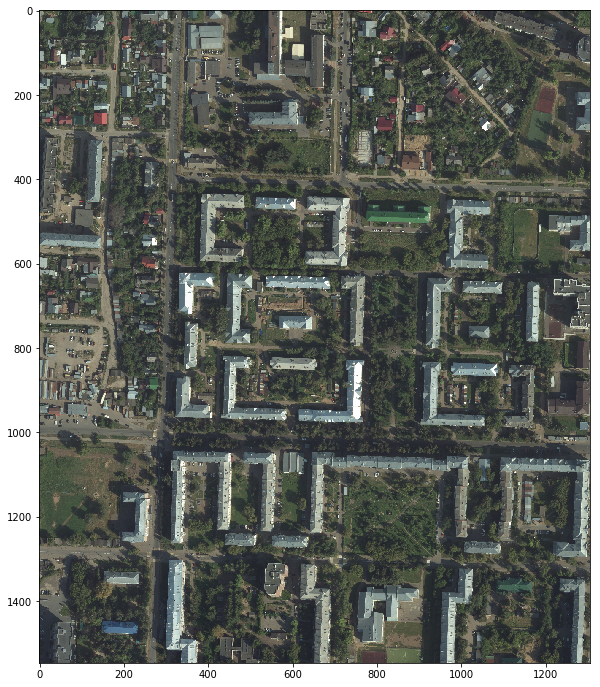

In [56]:
plt.figure(figsize=(12,12))
plt.imshow(test_images['P2MLF2MV9K9XIYUI']['image'][::5, ::5])
plt.show()

In [28]:
images[1]['name']

'3.tif'

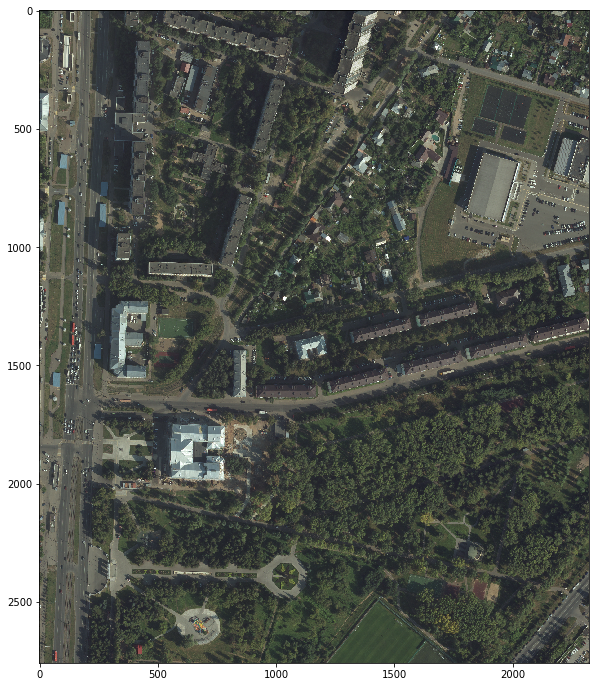

In [30]:
plt.figure(figsize=(12,12))
plt.imshow(images[1]['image'].transpose(1,2,0)[::5, ::5])
plt.show()

In [31]:
test_image.shape

(7736, 6530, 3)

In [32]:
gt_image = images[1]['image'].transpose(1,2,0)

In [33]:
gt_image.shape

(13789, 11618, 3)

In [34]:
13789/7736

1.782445708376422

In [37]:
11618/6530

1.7791730474732006

In [38]:
from rasterio.warp import calculate_default_transform

calculate_default_transform('epsg:3857', 'epsg:3857', )